# Стохастический градиентный спуск (20 баллов)

In [1]:
import os
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Optimizer

import torchvision
from torchvision.datasets.utils import download_url
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Основная часть (всего 10 баллов)

__Задача 1.__ В этой работе вы будете реализовывать стохастические методы на библиотеке torch. В основной части рассмотрим логистическую регрессию на [датасете](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a) из библиотеки LIBSVM.

__а) (1 балл)__ Реализуйте класс `LIBSVM` для работы с данными во время обучения/валидации. Допишите метод инициализации класса:
1. С помощью функции `load_svmligh_file` распарсите файл, лежащий в директории `file_dir`;
2. Преобразуйте дата-матрицу $X$ в формат `torch.Tensor` (воспользуйтесь функцией `torch.from_numpy`);
3. Выполните нормализацию данных по второй норме для каждой строки;
3. Преобразуйте вектор меток $y$ в формат `torch.Tensor`, а также приведите метки к значениям 0 и 1;
4. Разделите данные на обучающую и тестовую выборки, используя `train_test_split` с параметром `random_state=57`;
5. Преобразованные данные сохраните в атрибутах `self.train_dataset` и `self.test_dataset` как элементы класса `TensorDataset` (достаточно подать преобразованные тензоры $X$ и $y$ в него).

In [3]:
DOWNLOAD_LINKS = {'a9a': 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a'}

In [4]:

class LIBSVM(Dataset):
    def __init__(self, root, dataset_name, download=True, test_size=0.2, random_state=57):
        download_link = DOWNLOAD_LINKS[dataset_name]
        target = os.path.basename(download_link)
        file_dir = os.path.join(root, target)

        if not os.path.exists(file_dir):
            if download:
                download_url(download_link, root)
            else:
                raise FileNotFoundError(f"{file_dir} не существует")

        X, y = load_svmlight_file(file_dir)
        X_tensor = torch.from_numpy(X.toarray()).float()
        y_tensor = torch.from_numpy(y).float()

        X_tensor = F.normalize(X_tensor, p=2, dim=1)
        y_tensor = (y_tensor > 0).float()

        X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=test_size, random_state=random_state)
        self.train_dataset = TensorDataset(X_train, y_train)
        self.test_dataset = TensorDataset(X_test, y_test)


    def __getitem__(self, index):
        """
        Получение одного элемента из набора данных
        """
        return self.dataset.__getitem__(index)

    def __len__(self):
        """
        Количество элементов в наборе данных
        """
        return self.dataset.__len__()

In [5]:
test = LIBSVM(root='.', dataset_name='a9a')
test.train_dataset

100%|██████████| 2.33M/2.33M [00:00<00:00, 3.16MB/s]


__б) (1 балл)__ Создайте модель `LogisticRegression`, которая будет представлять из себя [`nn.Linear`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html) без `bias` с функцией активации [`F.sigmoid`](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.sigmoid.html).

_Указание: необходимо выдавать одно значение — вероятность, что метка принадлежит 1 классу._

In [6]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):

        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1, bias=False)

    def forward(self, x):

        return F.sigmoid(self.linear(x))

__в) (2 балла)__ Рассмотрите стохастический градиентный спуск (SGD). Допишите код метода. В нем должна быть реализована возможность использовать моментум (параметр `momentum`), а также $L_2$-регуляризацию для каждого параметра (параметр `weight_decay`).

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^0 \in \mathbb{R}^d$
- Начальный буфер $v^0 \in \mathbb{R}^d$
- Размер шага $\{ \gamma_k \}_{k=0} > 0$
- Моментумы $\{ \tau_k \}_{k=0} > 0$
- Коэффициент $L_2$-регуляризации $\lambda \geq 0$

---

$k$_-ая итерация_:

1. Вычислить градиент и применить $L_2$-регуляризацию:

$$
g^{k + 1} = \nabla f_i \left(x^k\right) + \lambda x^k
$$

2. Обновить буфер моментума:

$$
v^{k+1} = \tau_k v^{k} + g^{k+1}.
$$

3. Обновить параметры:

$$
x^{k+1} = x^k - \gamma_k v^{k+1}
$$

In [7]:
class SGD(Optimizer):
    """
    Реализация стохастического градиентного спуска с моментумом и L2-регуляризацией.

    Параметры:
        params (Iterable): Итерируемый объект параметров для оптимизации или словарь
        lr (float): Скорость обучения
        momentum (float): Коэффициент моментума
        weight_decay (float): Коэффициент L2-регуляризации
    """

    def __init__(self, params, lr=1e-3, momentum=0, weight_decay=0):
        if lr < 0.0:
            raise ValueError(f"Неверный шаг: {lr}")
        if momentum < 0.0:
            raise ValueError(f"Неверный моментум: {momentum}")
        if weight_decay < 0.0:
            raise ValueError(f"Неверный коэффициент L2-регуляризации: {weight_decay}")

        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay)
        super(SGD, self).__init__(params, defaults)

    def step(self, closure=None):
        """
        Выполняет один шаг оптимизатора.

        Параметры:
            closure (Сallable): Замыкание, которое пересчитывает модель и возвращает loss
        """

        loss = closure() if closure is not None else None

        g_0 = 0
        v_0 = 0
        x_0 = 0

        for group in self.param_groups:
            lr = group['lr']
            momentum = group['momentum']
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data

                if weight_decay != 0:
                    grad.add_(p.data, alpha=weight_decay)

                param_state = self.state[p]

                if 'momentum_buffer' not in param_state:
                    buf = param_state['momentum_buffer'] = torch.clone(grad).detach()
                else:
                    buf = param_state['momentum_buffer']
                    buf.mul_(momentum).add_(grad)

                p.data.add_(buf, alpha=-lr)

        return loss

__г) (2 балла)__ Реализуйте метод `trainer`, который принимает на вход все необходимые параметры для обучения и выполняет обучение и валидацию модели на протяжении заданного числа эпох. Допишите оберточные функции `train` и `test` для каждой эпохи обучения.

In [8]:
def trainer(num_epochs, batch_size, model_class, criterion, optimizer_class,
            optimizer_params, dataset, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Универсальная функция для обучения моделей PyTorch.

    Параметры:
        num_epochs (int): Количество эпох обучения
        batch_size (int): Размер батча для DataLoader
        model_class (nn.Module): Класс модели
        criterion (nn.Module): Функция потерь
        optimizer_class (optim.Optimizer): Класс оптимизатора
        optimizer_params (dict): Параметры оптимизатора
        dataset (Dataset): Объект датасета
        device (str): Устройство для вычислений

    Возвращает:
        tuple: (train_losses, train_accuracies, test_losses, test_accuracies)
            train_losses: значения потерь на обучении
            train_accuracies: значения accuracy на обучении
            test_losses: значения потерь на тесте
            test_accuracies: значения accuracy на тесте
    """
    # Инициализация DataLoader
    train_loader = DataLoader(dataset.train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset.test_dataset, batch_size=batch_size, shuffle=False)

    # Определение размерности входа
    input_dim = dataset.train_dataset[0][0].shape[0]

    # Инициализация модели
    model = model_class(input_dim=input_dim).to(device)
    optimizer = optimizer_class(model.parameters(), **optimizer_params)

    # Метрики
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    # Функции для train/test одной эпохи
    def train_epoch(epoch):
        model.train()

        total_loss = 0.0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()

            outputs = model(X_batch).squeeze()

            loss = criterion(outputs, y_batch)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X_batch.size(0)
            preds = (outputs > 0.5).float()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss = total_loss / total
        train_acc = 100.0 * correct / total

        return train_loss, train_acc

    def test_epoch(epoch):
        model.eval()

        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch).squeeze()
                loss = criterion(outputs, y_batch)

                total_loss += loss.item() * X_batch.size(0)
                preds = (outputs > 0.5).float()
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        test_loss = total_loss / total
        test_acc = 100.0 * correct / total

        return test_loss, test_acc

    # Основной цикл обучения
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(epoch)
        test_loss, test_acc = test_epoch(epoch)

        # Сохранение метрик
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Вывод статистики
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch + 1} / {num_epochs} | '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
              f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}% | '
              f'Time: {epoch_time:.2f}s')

    return train_losses, train_accuracies, test_losses, test_accuracies

__д) (1 балл)__ Запустите обучение с предложенной ниже конфигурацией.

In [9]:
config = {
    'num_epochs': 50,
    'batch_size': 120,
    'model_class': LogisticRegression,
    'criterion': nn.BCELoss(reduction='sum'),
    'optimizer_class': SGD,
    'optimizer_params': {'lr': 1e-3, 'momentum': 0.9, 'weight_decay': 1e-6},
    'dataset': LIBSVM(root='./data', dataset_name='a9a'),
    'device' : 'cpu'
}

# Запуск обучения
train_loss, train_acc, test_loss, test_acc = trainer(**config)

100%|██████████| 2.33M/2.33M [00:00<00:00, 3.15MB/s]


Epoch 1 / 50 | Train Loss: 50.5088 | Train Acc: 80.59% | Test Loss: 44.8189 | Test Acc: 82.74% | Time: 0.35s
Epoch 2 / 50 | Train Loss: 42.6077 | Train Acc: 83.65% | Test Loss: 42.7508 | Test Acc: 83.25% | Time: 0.31s
Epoch 3 / 50 | Train Loss: 41.1714 | Train Acc: 84.11% | Test Loss: 41.8305 | Test Acc: 83.54% | Time: 0.31s
Epoch 4 / 50 | Train Loss: 40.4352 | Train Acc: 84.31% | Test Loss: 41.4303 | Test Acc: 83.40% | Time: 0.31s
Epoch 5 / 50 | Train Loss: 40.0298 | Train Acc: 84.46% | Test Loss: 41.0385 | Test Acc: 83.54% | Time: 0.33s
Epoch 6 / 50 | Train Loss: 39.7494 | Train Acc: 84.51% | Test Loss: 40.7854 | Test Acc: 83.51% | Time: 0.32s
Epoch 7 / 50 | Train Loss: 39.5176 | Train Acc: 84.60% | Test Loss: 40.6993 | Test Acc: 83.56% | Time: 0.31s
Epoch 8 / 50 | Train Loss: 39.4159 | Train Acc: 84.66% | Test Loss: 40.5227 | Test Acc: 83.62% | Time: 0.33s
Epoch 9 / 50 | Train Loss: 39.2853 | Train Acc: 84.74% | Test Loss: 40.4757 | Test Acc: 83.82% | Time: 0.32s
Epoch 10 / 50 | Tra

Постройте сравнительные графики значений функции потерь и значений метрики `accuracy` в зависимости от числа эпох.

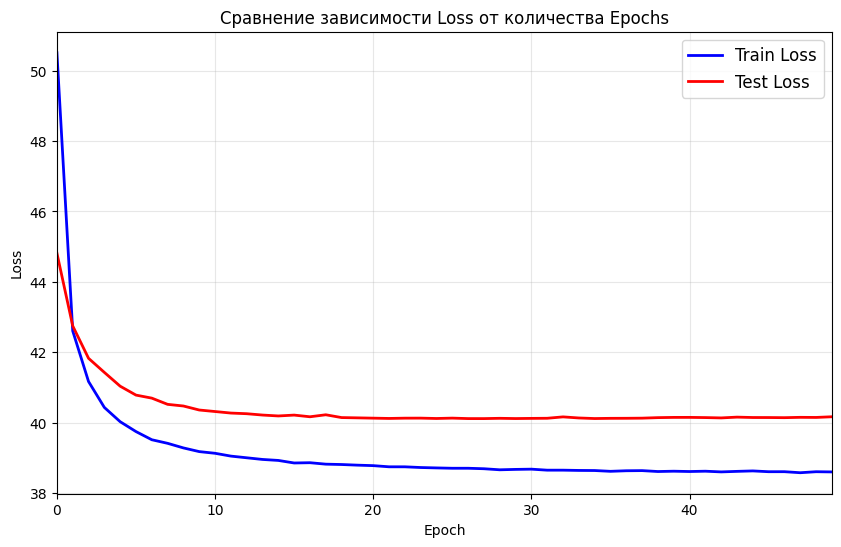

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss', linewidth=2, color='blue')
plt.plot(test_loss, label='Test Loss', linewidth=2, color='red')
plt.title('Сравнение зависимости Loss от количества Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, len(train_loss)-1)
plt.show()

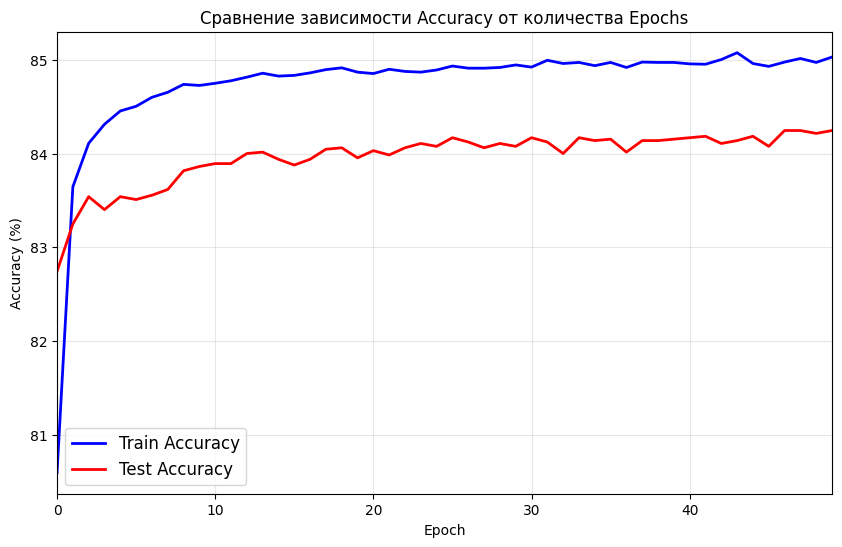

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Train Accuracy', linewidth=2, color='blue')
plt.plot(test_acc, label='Test Accuracy', linewidth=2, color='red')
plt.title('Сравнение зависимости Accuracy от количества Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, len(train_acc)-1)
plt.show()

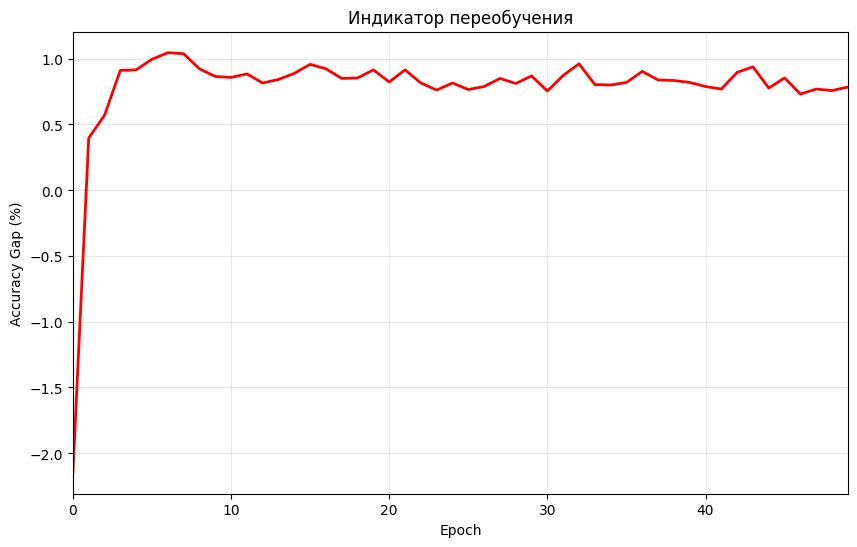

In [12]:
accuracy_gap = [train_acc[i] - test_acc[i] for i in range(len(train_acc))]
plt.figure(figsize=(10, 6))
plt.plot(accuracy_gap, color='red', linewidth=2)
plt.title('Индикатор переобучения')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Gap (%)')
plt.grid(True, alpha=0.3)
plt.xlim(0, len(accuracy_gap)-1)
plt.show()

Переобучения не возникло.

__Задача 2.__ В предыдущей задаче мы убедились, что даже простая модель быстро достигает высокой точности на табличных данных — достаточно одной эпохи для получения высокого значения метрики. Однако в реальных задачах, данные сложнее, и выбор гиперпараметров играет важную роль. В этом задании мы посмотрим, как размер батча влияет на качество обучения и скорость сходимости модели на примере датасета [`FashionMNIST`](https://www.kaggle.com/datasets/zalando-research/fashionmnist).

In [13]:
class FashionMNIST(Dataset):
    def __init__(self, root='.', download=True):
        transform = transforms.Compose([
            transforms.ToTensor()
        ])

        self.train_dataset = torchvision.datasets.FashionMNIST(
            root=root, train=True, download=download, transform=transform)
        self.test_dataset = torchvision.datasets.FashionMNIST(
            root=root, train=False, download=download, transform=transform)

    def __getitem__(self, index):
        """
        Получение одного элемента из набора данных
        """
        return self.dataset.__getitem__(index)

    def __len__(self):
        """
        Количество элементов в наборе данных
        """
        return self.dataset.__len__()

In [14]:
FashionMNIST_dataset = FashionMNIST(root='.')

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.90MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.1MB/s]


In [15]:
fashion_classes = (
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
)

def imshow_fashionmnist(img, ax=None, title=None):
    npimg = img.numpy().squeeze()  # (1, H, W) → (H, W)
    if ax is None:
        plt.imshow(npimg, cmap='gray')
        if title:
            plt.title(title)
        plt.axis('off')
    else:
        ax.imshow(npimg, cmap='gray')
        if title:
            ax.set_title(title)
        ax.axis('off')

def show_fashionmnist_samples(dataset, num_samples=20, rows=4, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    indices = np.random.choice(len(dataset), size=num_samples, replace=False)

    for idx, ax in zip(indices, axes):
        image, label = dataset[idx]
        imshow_fashionmnist(image, ax=ax, title=fashion_classes[label])

    for j in range(num_samples, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

Amount of train samples: 60000
Amount of test samples: 10000


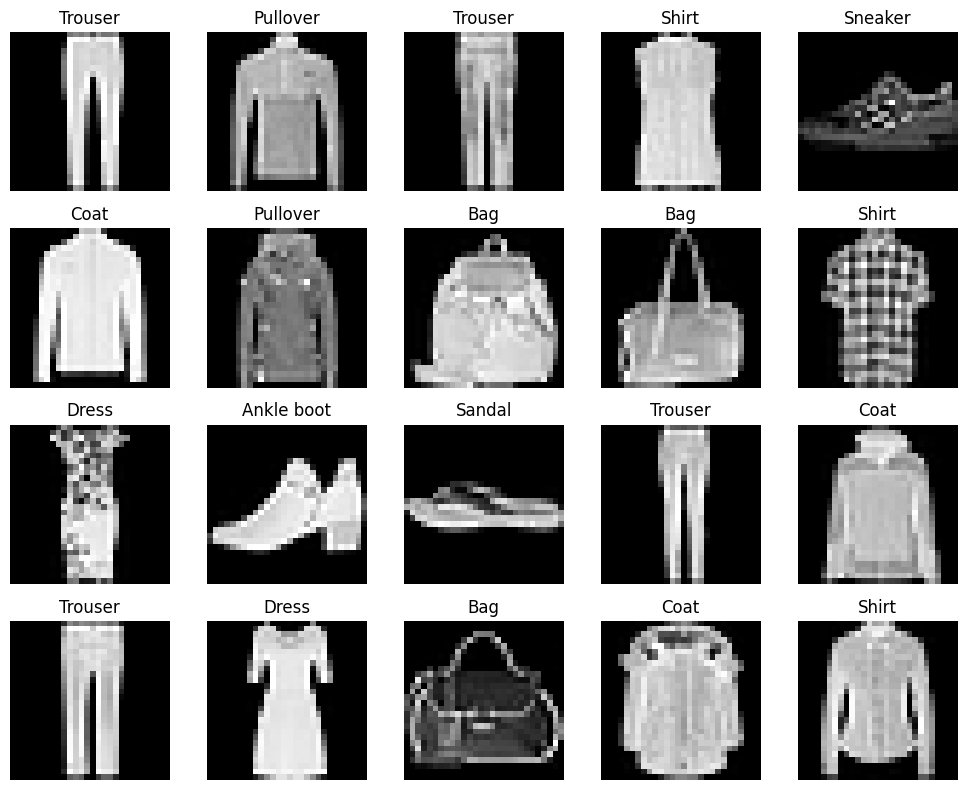

In [16]:
print(f"Amount of train samples: {len(FashionMNIST_dataset.train_dataset)}")
print(f"Amount of test samples: {len(FashionMNIST_dataset.test_dataset)}")

show_fashionmnist_samples(FashionMNIST_dataset.train_dataset)

__а) (1 балл)__ Рассмотрим более глубокую нейронную сеть, так как логистическая регрессия недостаточно хорошо приближает распределение данных в датасете F-MNIST. Реализуйте Multi-Layerd Perceptron (MLP), считая известным, что F-MNIST состоит из картинок размера 28*28, а число классов в нем равно 10:
1. [nn.Flatten()](https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html)
2. [nn.Linear(input_size, hidden_size)](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)
3. [nn.Relu()](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
4. [nn.Linear(hidden_size, num_classes)](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)

In [17]:
class MLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=256, num_classes=10):

        super(MLP, self).__init__()

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):

        return self.linear2(self.relu(self.linear1(self.flatten(x))))

__б) (1 балл)__ Модифицируйте метод `trainer`, добавив поддержку многоклассовой классификации.

In [18]:
def trainer(num_epochs, batch_size, model_class, criterion, optimizer_class,
            optimizer_params, dataset, device='cuda' if torch.cuda.is_available() else 'cpu'):

    """
    Универсальная функция для обучения моделей PyTorch.

    Параметры:
        num_epochs (int): Количество эпох обучения
        batch_size (int): Размер батча для DataLoader
        model_class (nn.Module): Класс модели
        criterion (nn.Module): Функция потерь
        optimizer_class (optim.Optimizer): Класс оптимизатора
        optimizer_params (dict): Параметры оптимизатора
        dataset (Dataset): Объект датасета
        device (str): Устройство для вычислений

    Возвращает:
        tuple: (train_losses, train_accuracies, test_losses, test_accuracies)
            train_losses: значения потерь на обучении
            train_accuracies: значения accuracy на обучении
            test_losses: значения потерь на тесте
            test_accuracies: значения accuracy на тесте
    """
    # Инициализация DataLoader
    train_loader = DataLoader(dataset.train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset.test_dataset, batch_size=batch_size, shuffle=False)

    # Инициализация модели
    model = model_class().to(device)
    optimizer = optimizer_class(model.parameters(), **optimizer_params)

    # Метрики
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    # Функции для train/test одной эпохи
    def train_epoch(epoch):
        model.train()

        total_loss = 0.0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss = total_loss / total
        train_acc = 100.0 * correct / total

        return train_loss, train_acc

    def test_epoch(epoch):
        model.eval()

        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                total_loss += loss.item() * X_batch.size(0)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        test_loss = total_loss / total
        test_acc = 100.0 * correct / total

        return test_loss, test_acc

    # Основной цикл обучения
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(epoch)
        test_loss, test_acc = test_epoch(epoch)

        # Сохранение метрик
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Вывод статистики
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch + 1} / {num_epochs} | '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
              f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}% | '
              f'Time: {epoch_time:.2f}s')

    return train_losses, train_accuracies, test_losses, test_accuracies

__в) (1 балл)__ Исследуйте влияние размера батча на качество модели. Используя предоставленный шаблон, постройте сравнительные графики значений функции потерь и значений метрики `accuracy` в зависимости от размера батча.

In [19]:
batch_sizes = [32, 64, 128, 256]

base_lr = 1e-3

train_acc_list=[]
test_acc_list=[]
train_loss_list=[]
test_loss_list=[]

for batch_size in batch_sizes:
    print(f"\n=== Training with batch size: {batch_size} ===")
    config = {
        'num_epochs': 10,
        'model_class': MLP,
        'criterion': nn.CrossEntropyLoss(reduction='sum'),
        'optimizer_class': SGD,
        'optimizer_params': {
            'lr': base_lr * np.sqrt(batch_size / 32),
            'momentum': 0.8,
            'weight_decay': 1e-4,
        },
        'dataset': FashionMNIST(),
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'batch_size': batch_size
    }

    train_loss, train_acc, test_loss, test_acc = trainer(**config)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)




=== Training with batch size: 32 ===
Epoch 1 / 10 | Train Loss: 16.7530 | Train Acc: 81.15% | Test Loss: 14.5679 | Test Acc: 82.79% | Time: 10.33s
Epoch 2 / 10 | Train Loss: 12.4725 | Train Acc: 85.77% | Test Loss: 14.0208 | Test Acc: 84.46% | Time: 9.82s
Epoch 3 / 10 | Train Loss: 11.3197 | Train Acc: 87.04% | Test Loss: 12.7530 | Test Acc: 85.45% | Time: 9.32s
Epoch 4 / 10 | Train Loss: 10.5976 | Train Acc: 87.82% | Test Loss: 11.6428 | Test Acc: 86.67% | Time: 9.63s
Epoch 5 / 10 | Train Loss: 10.0172 | Train Acc: 88.41% | Test Loss: 12.3705 | Test Acc: 86.40% | Time: 9.75s
Epoch 6 / 10 | Train Loss: 9.4827 | Train Acc: 89.04% | Test Loss: 12.1857 | Test Acc: 86.44% | Time: 9.71s
Epoch 7 / 10 | Train Loss: 9.1028 | Train Acc: 89.43% | Test Loss: 11.7369 | Test Acc: 86.74% | Time: 9.65s
Epoch 8 / 10 | Train Loss: 8.8859 | Train Acc: 89.49% | Test Loss: 11.3088 | Test Acc: 87.32% | Time: 9.73s
Epoch 9 / 10 | Train Loss: 8.4749 | Train Acc: 90.05% | Test Loss: 11.0808 | Test Acc: 87.67

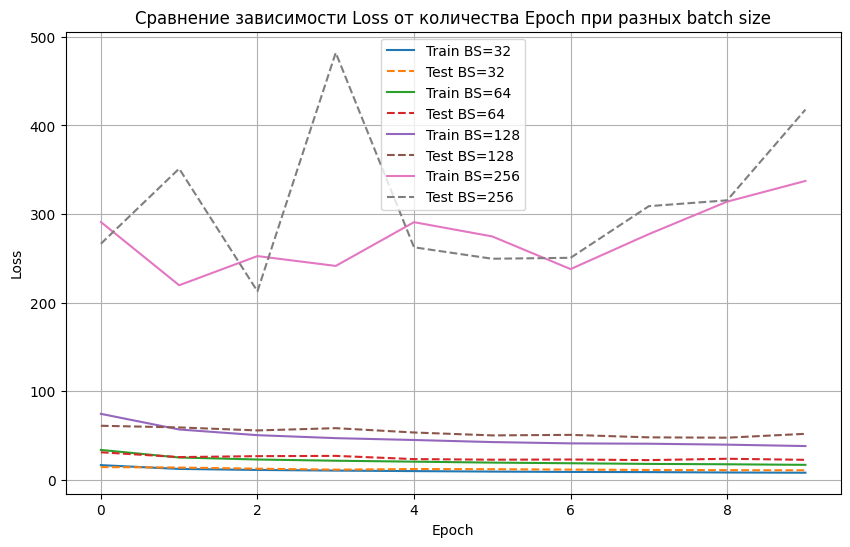

In [20]:
plt.figure(figsize=(10, 6))
for i, batch_size in enumerate(batch_sizes):
    plt.plot(train_loss_list[i], label=f'Train BS={batch_size}')
    plt.plot(test_loss_list[i], linestyle='--', label=f'Test BS={batch_size}')
plt.title('Сравнение зависимости Loss от количества Epoch при разных batch size')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

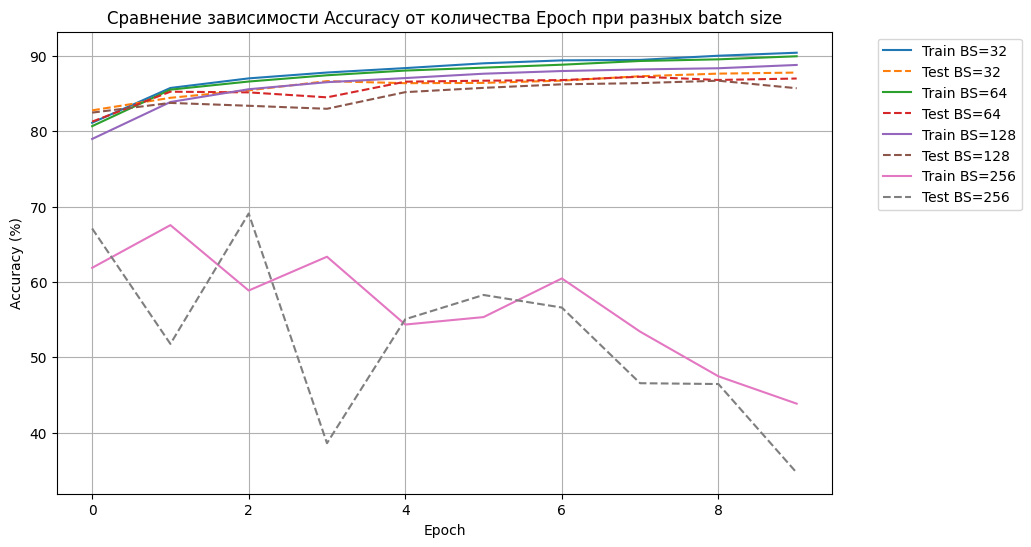

In [21]:
plt.figure(figsize=(10, 6))
for i, batch_size in enumerate(batch_sizes):
    plt.plot(train_acc_list[i], label=f'Train BS={batch_size}')
    plt.plot(test_acc_list[i], linestyle='--', label=f'Test BS={batch_size}')
plt.title('Сравнение зависимости Accuracy от количества Epoch при разных batch size')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

## Дополнительная часть (10 баллов)

In [22]:
import warnings
warnings.filterwarnings("ignore")

from torch import optim
from torchvision.models import resnet18

__Задача 2.__ В данной части будут рассмотрены не столь "игрушечные" датасеты, а уже проверенный временем бенчмарк для компьютерного зрения — связка из датасета [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) (картинки 32 $\times$ 32, 50,000 сэмплов train, 10,000 сэмплов test, 10 классов) и нейронной архитектуры [ResNet18](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html). Так как курс посвящен оптимизации, то предлагается импортировать саму архитектуру (без непосредственной реализации) и работать с ней в парадигме "black-box" оптимизации — дан черный ящик в виде модели, хотим достичь наилучшего качества обучения.

In [23]:
class CIFAR10(Dataset):
    def __init__(self, root, download=True, normalize_mean=(0.5, 0.5, 0.5), normalize_std=(0.5, 0.5, 0.5)):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std)
        ])

        self.train_dataset = torchvision.datasets.CIFAR10(
            root = '.',
            train = True,
            transform = transform,
            download = download,
        )
        self.test_dataset = torchvision.datasets.CIFAR10(
            root = '.',
            train = False,
            transform = transform,
            download = download,
        )

    def __getitem__(self, index):
        """
        Получение одного элемента из набора данных
        """
        return self.dataset.__getitem__(index)

    def __len__(self):
        """
        Количество элементов в наборе данных
        """
        return self.dataset.__len__()

In [24]:
CIFAR10_dataset = CIFAR10(root='.')

100%|██████████| 170M/170M [00:03<00:00, 48.9MB/s]


In [25]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img, ax=None, title=None):
    img = img / 2 + 0.5
    npimg = img.numpy()
    if ax is None:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        if title:
            plt.title(title)
        plt.axis('off')
    else:
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        if title:
            ax.set_title(title)
        ax.axis('off')


def show_dataset_samples(dataset, num_samples=20, rows=4, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    indices = np.random.choice(len(dataset), size=num_samples, replace=False)

    for i, ax in enumerate(zip(indices, axes)):
        image, label = dataset[i]
        imshow(image, ax=ax[1], title=classes[label])

    for j in range(num_samples, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

Amount of train samples: 50000
Amount of test samples: 10000


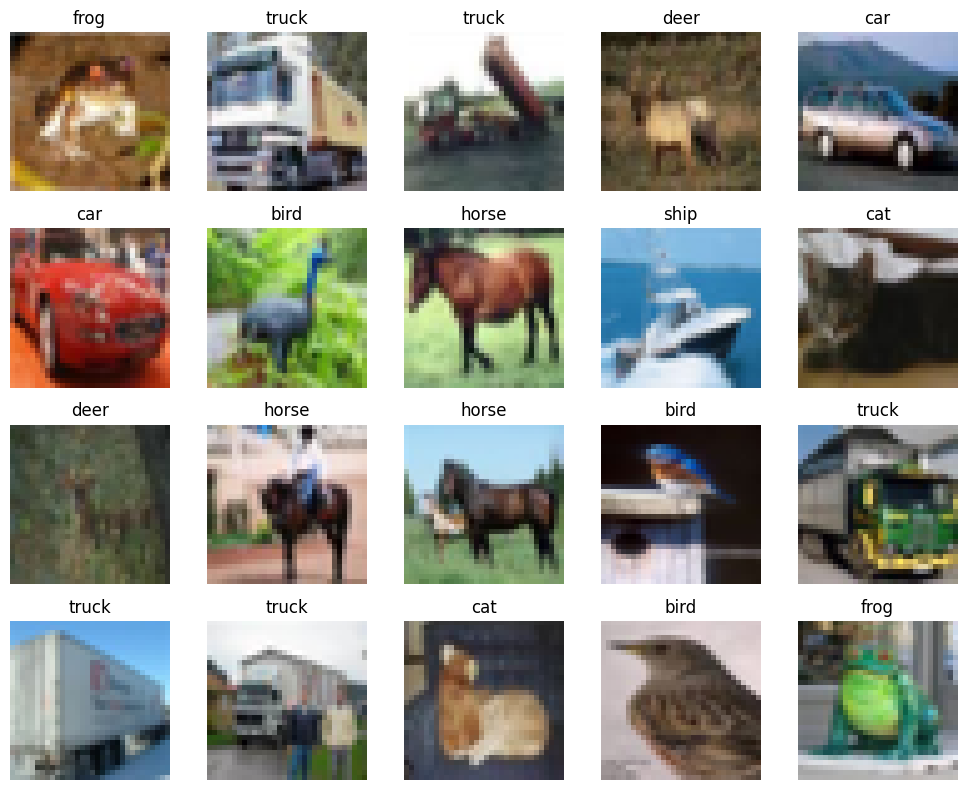

In [26]:
print(f"Amount of train samples: {len(CIFAR10_dataset.train_dataset)}")
print(f"Amount of test samples: {len(CIFAR10_dataset.test_dataset)}")

show_dataset_samples(CIFAR10_dataset.train_dataset)

Теперь проинициализируем сверточную модель `ResNet18` ([оригинальная статья](https://arxiv.org/abs/1512.03385), [реализация в torch](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html)), для желающих разобраться, из каких слоев она состоит, добавлена функция `print_model_summary`, в которой перечислены все слои и число обучаемых параметров.

In [27]:
# Число классов в датасете - 10
resnet = resnet18(weights=None, num_classes=10)

In [28]:
def print_model_summary(model, input_size):
    def register_hook(module):
        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)

            m_key = f"{class_name}-{module_idx+1}"
            summary[m_key] = {
                "input_shape": list(input[0].size()),
                "output_shape": list(output.size()),
                "nb_params": sum(p.numel() for p in module.parameters())
            }

        if not isinstance(module, nn.Sequential) and not isinstance(module, nn.ModuleList) and module != model:
            hooks.append(module.register_forward_hook(hook))

    summary = {}
    hooks = []

    model.apply(register_hook)

    model.eval()
    with torch.no_grad():
        model(torch.zeros(1, *input_size))

    for h in hooks:
        h.remove()

    print("----------------------------------------------------------------")

    line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
    print(line_new)
    print("================================================================")

    total_params = 0

    for layer in summary:
        line_new = "{:>20}  {:>25} {:>15}".format(
            layer,
            str(summary[layer]["output_shape"]),
            "{0:,}".format(summary[layer]["nb_params"])
        )

        total_params += summary[layer]["nb_params"]

        print(line_new)

    print("================================================================")
    print(f"Total params: {total_params:,}")
    print("----------------------------------------------------------------")

# Входной размер картинки - (3, 32, 32), так как она RGB-шная
print_model_summary(resnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 16, 16]           9,408
       BatchNorm2d-2            [1, 64, 16, 16]             128
              ReLU-3            [1, 64, 16, 16]               0
         MaxPool2d-4              [1, 64, 8, 8]               0
            Conv2d-5              [1, 64, 8, 8]          36,864
       BatchNorm2d-6              [1, 64, 8, 8]             128
              ReLU-7              [1, 64, 8, 8]               0
            Conv2d-8              [1, 64, 8, 8]          36,864
       BatchNorm2d-9              [1, 64, 8, 8]             128
             ReLU-10              [1, 64, 8, 8]               0
       BasicBlock-11              [1, 64, 8, 8]          73,984
           Conv2d-12              [1, 64, 8, 8]          36,864
      BatchNorm2d-13              [1, 64, 8, 8]             128
             ReLU-14              [1, 6

__a) (5 баллов)__ Рассмотрите несколько типов `lr_scheduler` — планировщика скорости обучения, предоставлямых библиотекой `torch`:

1) [`LambdaLR`](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LambdaLR.html)

$$
lr_{epoch + 1} = lr_{base} \cdot \lambda(epoch + 1)
$$

2) [`ExponentialLR`](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html)

$$
lr_{epoch + 1} = \gamma \cdot lr_{epoch}
$$

3) [`ReduceLRonPlateu`](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html)

    Шаг уменьшается на фактор при достижении плато в функции ошибок.

4) [`CosinAnnealingLR`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html)

$$
lr_{epoch + 1} = \eta_{\min} + \frac{1}{2}(\eta_{\max} - \eta_{\min})
    \left(1 + \cos \left(\frac{\pi (epoch + 1)}{T_{\max}}\right)\right)
$$

5) [`LinearLR`](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html)

$$
lr_{epoch + 1} = lr_{base} \cdot \left(\alpha + \left(1 - \alpha \right) \left(1 - \frac{epoch + 1}{T_{\max}}\right) \right)
$$

Для удобства дальнейшего использования предлагается функция `get_lr_schedule`.

In [30]:
def get_lr_schedule(model_class, optimizer_class, optimizer_params, scheduler_class, scheduler_params,
                    num_epochs=100, dummy_loss=None):
    """
    Возвращает список значений learning rate для заданного планировщика.

    Параметры:
        model_class (nn.Module): Модель
        optimizer_class (optim.Optimizer): Оптимизатор
        optimizer_params (dict): Параметры оптимизатора
        scheduler_class (optim.lr_scheduler): Планировщик скорости обучения
        scheduler_params (dict): Параметры планировщика
        num_epochs (int): Количество эпох для симуляции
        dummy_loss (list or None): Список значений потерь для ReduceLROnPlateau

    Возвращает:
        lrs (list): Список learning rate на каждой итерации
    """

    model = model_class()
    optimizer = optimizer_class(model.parameters(), **optimizer_params)
    scheduler = scheduler_class(optimizer, **scheduler_params)

    lrs = []

    for i in range(num_epochs):
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            loss = dummy_loss[i] if dummy_loss is not None else 1.0
            scheduler.step(loss)
        else:
            scheduler.step()

        lrs.append(optimizer.param_groups[0]['lr'])

    return lrs

Изобразите поведение от номера эпохи `lr_scheduler`: `ExponentialLR`, `ReduceLRonPlateu`, `CosinAnnealingLR`, `LinearLR` (используйте готовые реализации в `torch`).

In [31]:
# Простая модель
class DummyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(10, 2)

    def forward(self, x):
        return self.linear(x)

In [34]:
num_epochs = 100
dummy_losses = [1.0 / (i + 1) for i in range(num_epochs - 30)] + [0.0001 for j in range(30)]


lr_exponential = get_lr_schedule(
    DummyModel, SGD,
    {'lr': 1e-2, 'momentum': 0.9, 'weight_decay': 1e-4},
    optim.lr_scheduler.ExponentialLR,
    {'gamma': 0.977},
    num_epochs=num_epochs
)

lr_plateau = get_lr_schedule(
    DummyModel, SGD,
    {'lr': 1e-2, 'momentum': 0.9, 'weight_decay': 1e-4},
    optim.lr_scheduler.ReduceLROnPlateau,
    {},
    num_epochs=num_epochs,
    dummy_loss=dummy_losses
)

lr_cosine = get_lr_schedule(
    DummyModel, SGD,
    {'lr': 1e-2, 'momentum': 0.9, 'weight_decay': 1e-4},
    optim.lr_scheduler.CosineAnnealingLR,
    {'T_max': num_epochs, 'eta_min': 1e-4},
    num_epochs=num_epochs
)

lr_linear = get_lr_schedule(
    DummyModel, SGD,
    {'lr': 1e-2, 'momentum': 0.9, 'weight_decay': 1e-4},
    optim.lr_scheduler.LinearLR,
    {},
    num_epochs=num_epochs
)

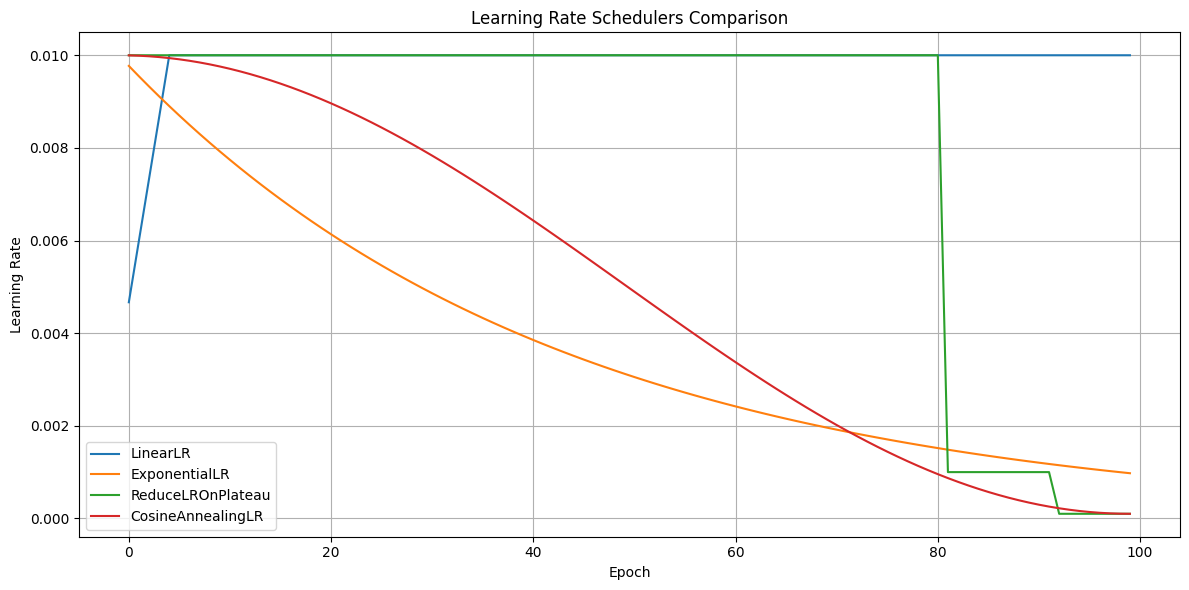

In [35]:
# Визуализация

plt.figure(figsize=(12, 6))
plt.plot(lr_linear, label="LinearLR")
plt.plot(lr_exponential, label="ExponentialLR")
plt.plot(lr_plateau, label="ReduceLROnPlateau")
plt.plot(lr_cosine, label="CosineAnnealingLR")

plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedulers Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Теперь применим соответсвующие скедулеры для связки `CIFAR10` + `ResNet18`. Дополните функцию `trainer` с обновлением шага раз в эпоху. Добавьте возможность использования скедулера/шедулера (`torch.optim.lr_scheduler`), а также убрав значения входных размерностей, так как они известны. В качестве оптимизатора используйте написанный класс `SGD` с параметром моментума равным 0.8. Постройте сравнительные графики функции ошибок и значений метрики для каждого скедулера. Какой скедулер показал себя лучше всего?

In [36]:
def trainer(num_epochs, batch_size, model_class, criterion, optimizer_class=SGD, optimizer_params=None,
            scheduler_class=None, scheduler_params=None, dataset=None,
            device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Универсальная функция для обучения моделей PyTorch.

    Параметры:
        num_epochs (int): Количество эпох обучения
        batch_size (int): Размер батча для DataLoader
        model_class (nn.Module): Класс модели
        criterion (nn.Module): Функция потерь
        optimizer_class (optim.Optimizer): Класс оптимизатора
        optimizer_params (dict): Параметры оптимизатора
        scheduler_class (optim.lr_scheduler): Класс планировщика скорости обучения
        scheduler_params (dict): Параметры планировщика скорости обучения
        dataset (Dataset): Объект датасета
        device (str): Устройство для вычислений

    Возвращает:
        model (nn.Module): Обученная модель
        metrics (dict): Словарь с логами
    """

    # Создаем загрузчики данных
    train_loader = DataLoader(dataset.train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset.test_dataset, batch_size=batch_size, shuffle=False)

    # Инициализируем модель, оптимизатор
    model = model_class.to(device)
    optimizer = optimizer_class(model.parameters(), **(optimizer_params or {}))

    # Инициализируем планировщик
    scheduler = None
    if scheduler_class is not None:
        scheduler = scheduler_class(optimizer, **(scheduler_params or {}))

    # Метрики
    metrics = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "learning_rates": []
    }

    def train_epoch(epoch):
        model.train()

        total_loss = 0.0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad(set_to_none=True)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss = total_loss / total
        train_acc = 100.0 * correct / total

        return train_loss, train_acc

    def test_epoch(epoch):
        model.eval()

        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                total_loss += loss.item() * X_batch.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        test_loss = total_loss / total
        test_acc = 100.0 * correct / total

        return test_loss, test_acc

    # Обучение
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(epoch)
        test_loss, test_acc = test_epoch(epoch)

        # Шаг планировщика

        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(test_loss)
            else:
                scheduler.step()

        # Сохраняем метрики
        metrics["train_loss"].append(train_loss)
        metrics["train_acc"].append(train_acc)
        metrics["test_loss"].append(test_loss)
        metrics["test_acc"].append(test_acc)
        metrics["learning_rates"].append(optimizer.param_groups[0]['lr'])

        # Логирование
        elapsed = time.time() - start_time
        print(f"Epoch {epoch + 1} / {num_epochs} | "
              f"LR: {metrics['learning_rates'][-1]:.2e} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}% | "
              f"Time: {elapsed:.2f}s")

    # Возвращаем модель и метрики
    return model, metrics

Посмотрим на работу одного `lr_scheduler`. Используйте его как пример в построении графиков.

In [37]:
resnet = resnet18(weights=None, num_classes=10)

config = {
    'num_epochs': 10,
    'batch_size': 128,
    'model_class': resnet,
    'criterion': nn.CrossEntropyLoss(reduction='mean'),
    'optimizer_class': SGD,
    'optimizer_params': {'lr': 1e-2, 'momentum': 0.8, 'weight_decay': 1e-4},
    'scheduler_class': optim.lr_scheduler.CosineAnnealingLR,
    'scheduler_params': {'T_max': 10, 'eta_min': 0.001},
    'dataset': CIFAR10_dataset,
    'device' : 'cuda',
}

# Запуск обучения
trained_resnet, metrics = trainer(**config)

Epoch 1 / 10 | LR: 9.78e-03 | Train Loss: 1.5414, Train Acc: 44.62% | Test Loss: 1.3761, Test Acc: 50.75% | Time: 28.88s
Epoch 2 / 10 | LR: 9.14e-03 | Train Loss: 1.1243, Train Acc: 59.89% | Test Loss: 1.1597, Test Acc: 59.74% | Time: 27.86s
Epoch 3 / 10 | LR: 8.15e-03 | Train Loss: 0.8922, Train Acc: 68.33% | Test Loss: 1.0597, Test Acc: 63.68% | Time: 28.37s
Epoch 4 / 10 | LR: 6.89e-03 | Train Loss: 0.7006, Train Acc: 75.08% | Test Loss: 1.0491, Test Acc: 65.12% | Time: 28.42s
Epoch 5 / 10 | LR: 5.50e-03 | Train Loss: 0.5220, Train Acc: 81.49% | Test Loss: 1.0571, Test Acc: 66.33% | Time: 28.42s
Epoch 6 / 10 | LR: 4.11e-03 | Train Loss: 0.3369, Train Acc: 88.46% | Test Loss: 1.1592, Test Acc: 67.53% | Time: 29.10s
Epoch 7 / 10 | LR: 2.85e-03 | Train Loss: 0.1705, Train Acc: 94.44% | Test Loss: 1.2663, Test Acc: 67.36% | Time: 28.74s
Epoch 8 / 10 | LR: 1.86e-03 | Train Loss: 0.0638, Train Acc: 98.48% | Test Loss: 1.3105, Test Acc: 69.30% | Time: 29.19s
Epoch 9 / 10 | LR: 1.22e-03 | Tr

Используя следующие параметры, постройте сравнительные графики функции ошибок и значений метрики для каждого `lr_scheduler`.

In [40]:
schedulers = {
    'CosineAnnealingLR': (optim.lr_scheduler.CosineAnnealingLR, {'T_max': 10, 'eta_min': 0.001}),
    'ExponentialLR': (optim.lr_scheduler.ExponentialLR, {'gamma': 0.9}),
    'ReduceLROnPlateau': (optim.lr_scheduler.ReduceLROnPlateau, {'mode': 'min', 'factor': 0.5, 'patience': 2}),
    'LinearLR': (optim.lr_scheduler.LinearLR, {'start_factor': 0.1, 'end_factor': 1.0, 'total_iters': 10}),
}

results = {}

for name, (scheduler_class, scheduler_params) in schedulers.items():
    resnet = resnet18(weights=None, num_classes=10)

    config = {
        'num_epochs': 10,
        'batch_size': 128,
        'model_class': resnet,
        'criterion': nn.CrossEntropyLoss(reduction='mean'),
        'optimizer_class': SGD,
        'optimizer_params': {'lr': 1e-2, 'momentum': 0.8, 'weight_decay': 1e-4},
        'scheduler_class': scheduler_class,
        'scheduler_params': scheduler_params,
        'dataset': CIFAR10_dataset,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    }

    trained_model, metrics = trainer(**config)
    results[name] = metrics

Epoch 1 / 10 | LR: 9.78e-03 | Train Loss: 1.5419, Train Acc: 44.30% | Test Loss: 1.3407, Test Acc: 51.31% | Time: 28.68s
Epoch 2 / 10 | LR: 9.14e-03 | Train Loss: 1.1527, Train Acc: 58.72% | Test Loss: 1.1437, Test Acc: 59.74% | Time: 28.63s
Epoch 3 / 10 | LR: 8.15e-03 | Train Loss: 0.9311, Train Acc: 66.96% | Test Loss: 1.0484, Test Acc: 63.29% | Time: 29.11s
Epoch 4 / 10 | LR: 6.89e-03 | Train Loss: 0.7406, Train Acc: 73.88% | Test Loss: 1.0247, Test Acc: 65.30% | Time: 28.74s
Epoch 5 / 10 | LR: 5.50e-03 | Train Loss: 0.5625, Train Acc: 80.12% | Test Loss: 1.0335, Test Acc: 66.91% | Time: 29.31s
Epoch 6 / 10 | LR: 4.11e-03 | Train Loss: 0.3802, Train Acc: 86.64% | Test Loss: 1.1112, Test Acc: 67.52% | Time: 28.69s
Epoch 7 / 10 | LR: 2.85e-03 | Train Loss: 0.2119, Train Acc: 92.94% | Test Loss: 1.1955, Test Acc: 68.47% | Time: 28.91s
Epoch 8 / 10 | LR: 1.86e-03 | Train Loss: 0.0896, Train Acc: 97.50% | Test Loss: 1.2811, Test Acc: 69.08% | Time: 28.71s
Epoch 9 / 10 | LR: 1.22e-03 | Tr

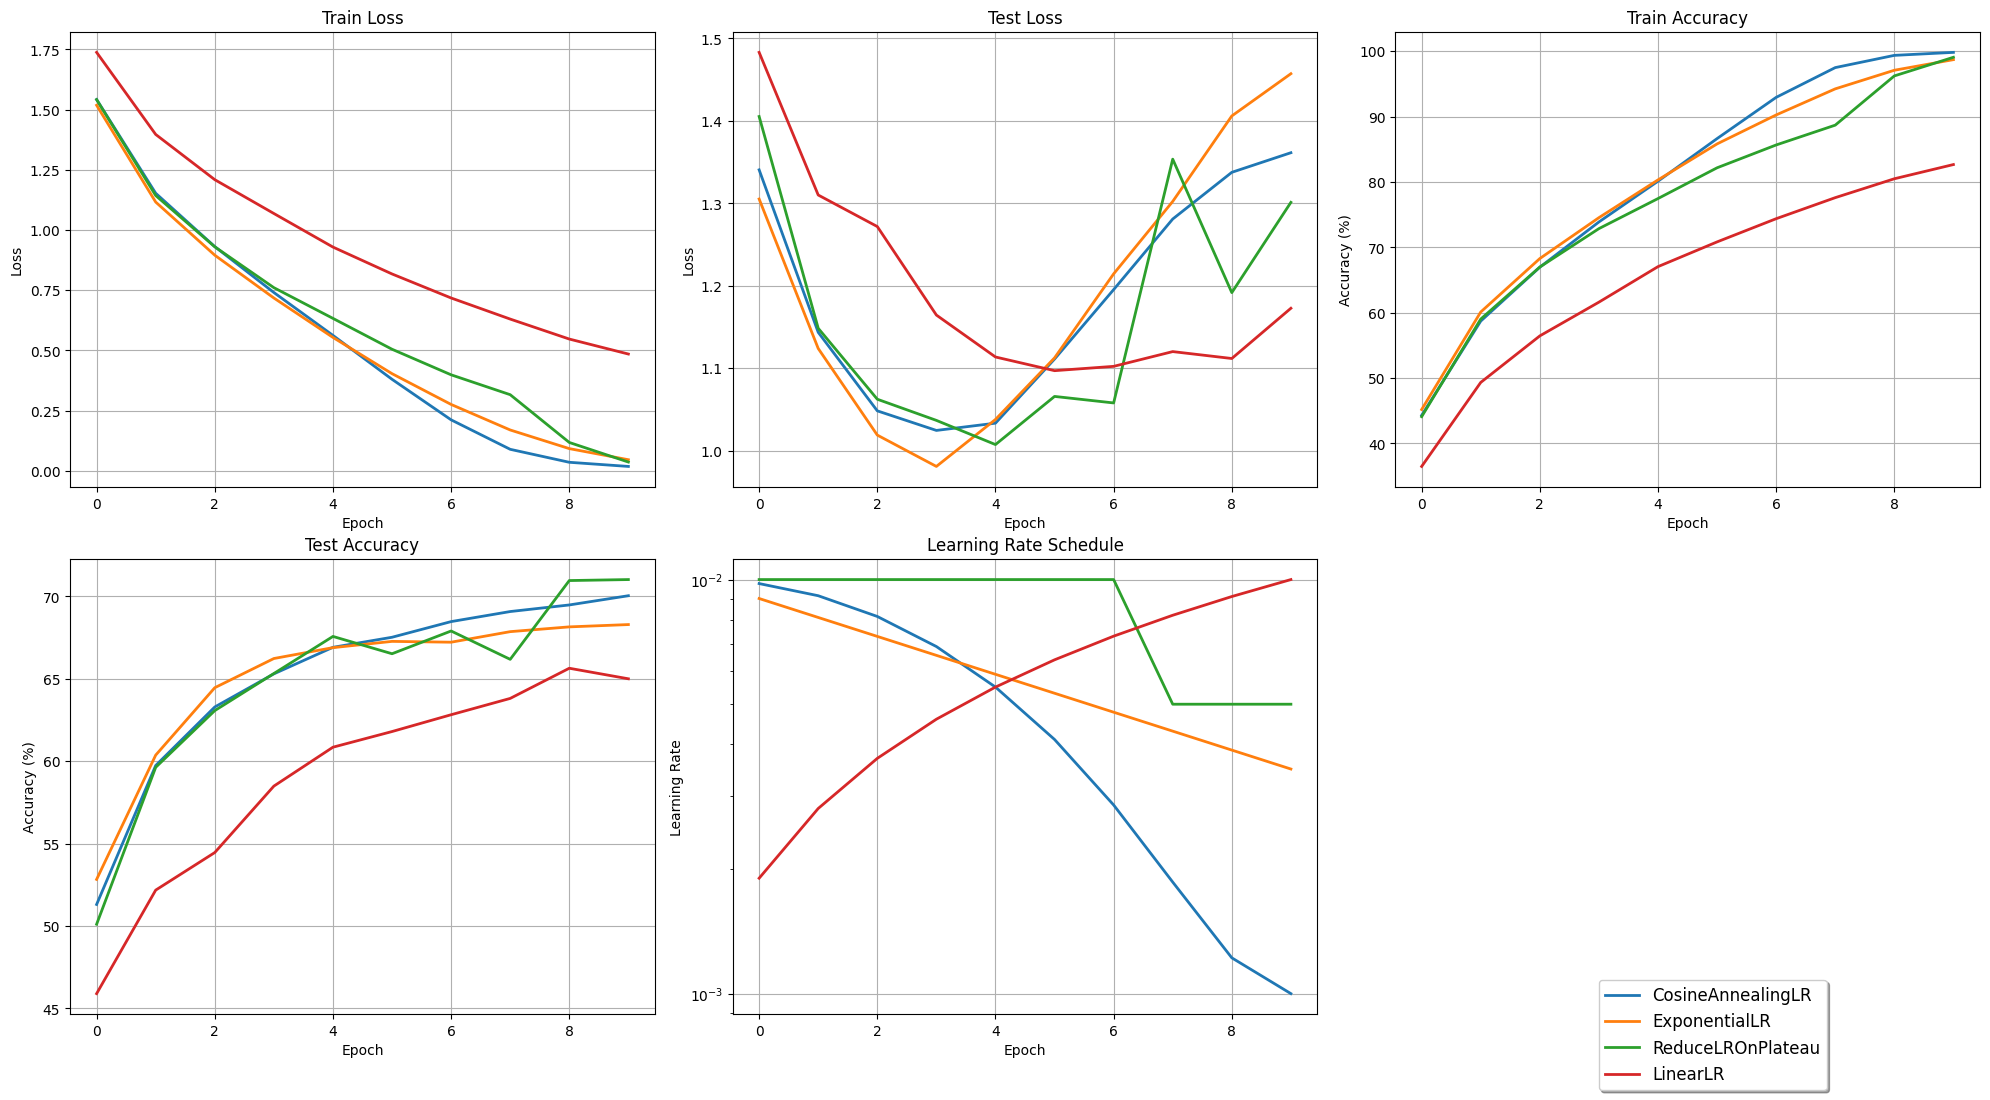

In [46]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

all_handles = []
all_labels = []

for name, metrics in results.items():
    line, = axes[0, 0].plot(metrics['train_loss'], linewidth=2)
    if name not in all_labels:
        all_handles.append(line)
        all_labels.append(name)
axes[0, 0].set_title('Train Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True)

for name, metrics in results.items():
    axes[0, 1].plot(metrics['test_loss'], linewidth=2)
axes[0, 1].set_title('Test Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(True)

for name, metrics in results.items():
    axes[0, 2].plot(metrics['train_acc'], linewidth=2)
axes[0, 2].set_title('Train Accuracy')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Accuracy (%)')
axes[0, 2].grid(True)

for name, metrics in results.items():
    axes[1, 0].plot(metrics['test_acc'], linewidth=2)
axes[1, 0].set_title('Test Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].grid(True)

for name, metrics in results.items():
    if name != 'No Scheduler':
        axes[1, 1].plot(metrics['learning_rates'], linewidth=2)
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].grid(True)
axes[1, 1].set_yscale('log')

fig.delaxes(axes[1, 2])

fig.legend(all_handles, all_labels,
           loc='lower right',
           bbox_to_anchor=(0.92, 0.08),
           fontsize=12,
           frameon=True,
           fancybox=True,
           shadow=True,
           ncol=1)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

Какой `lr_scheduler` показал себя лучше всего?

Судя по метрикам `test_accuracy` и `test_loss` лучше всего показал себя `ReduceLROnPlateau`

Посмотрим, чему научилась наша модель на картинках из тестового датасета. Возьмите для этого модель, которая достигла лучших показателей на тестовом датасете и передайте как параметр в предложенной функции визуализации.

In [48]:
resnet = resnet18(weights=None, num_classes=10)

config = {
    'num_epochs': 10,
    'batch_size': 128,
    'model_class': resnet,
    'criterion': nn.CrossEntropyLoss(reduction='mean'),
    'optimizer_class': SGD,
    'optimizer_params': {'lr': 1e-2, 'momentum': 0.8, 'weight_decay': 1e-4},
    'scheduler_class': schedulers['ReduceLROnPlateau'][0],
    'scheduler_params': schedulers['ReduceLROnPlateau'][1],
    'dataset': CIFAR10_dataset,
    'device' : 'cuda',
}

trained_resnet, metrics = trainer(**config)

Epoch 1 / 10 | LR: 1.00e-02 | Train Loss: 1.5110, Train Acc: 45.67% | Test Loss: 1.2854, Test Acc: 54.08% | Time: 28.83s
Epoch 2 / 10 | LR: 1.00e-02 | Train Loss: 1.1008, Train Acc: 60.85% | Test Loss: 1.0722, Test Acc: 62.31% | Time: 28.73s
Epoch 3 / 10 | LR: 1.00e-02 | Train Loss: 0.8914, Train Acc: 68.62% | Test Loss: 1.0059, Test Acc: 64.56% | Time: 29.47s
Epoch 4 / 10 | LR: 1.00e-02 | Train Loss: 0.7354, Train Acc: 73.87% | Test Loss: 0.9632, Test Acc: 67.48% | Time: 28.46s
Epoch 5 / 10 | LR: 1.00e-02 | Train Loss: 0.6060, Train Acc: 78.51% | Test Loss: 0.9884, Test Acc: 67.22% | Time: 29.28s
Epoch 6 / 10 | LR: 1.00e-02 | Train Loss: 0.4837, Train Acc: 82.78% | Test Loss: 1.0649, Test Acc: 66.80% | Time: 28.57s
Epoch 7 / 10 | LR: 5.00e-03 | Train Loss: 0.3893, Train Acc: 86.01% | Test Loss: 1.1232, Test Acc: 66.75% | Time: 28.56s
Epoch 8 / 10 | LR: 5.00e-03 | Train Loss: 0.1600, Train Acc: 94.74% | Test Loss: 1.1341, Test Acc: 70.09% | Time: 28.80s
Epoch 9 / 10 | LR: 5.00e-03 | Tr

In [49]:
def show_model_predictions(model, dataset, num_samples=20, rows=4, cols=5, device='cpu'):
    model.to(device)
    model.eval()

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
    axes = axes.flatten()

    indices = np.random.choice(len(dataset), size=num_samples, replace=False)

    for i, ax in enumerate(zip(indices, axes)):
        image, label = dataset[i]
        image_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)

        imshow(image, ax=ax[1], title=f"True: {classes[label]}\nPred: {classes[predicted.item()]}")

    for j in range(num_samples, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

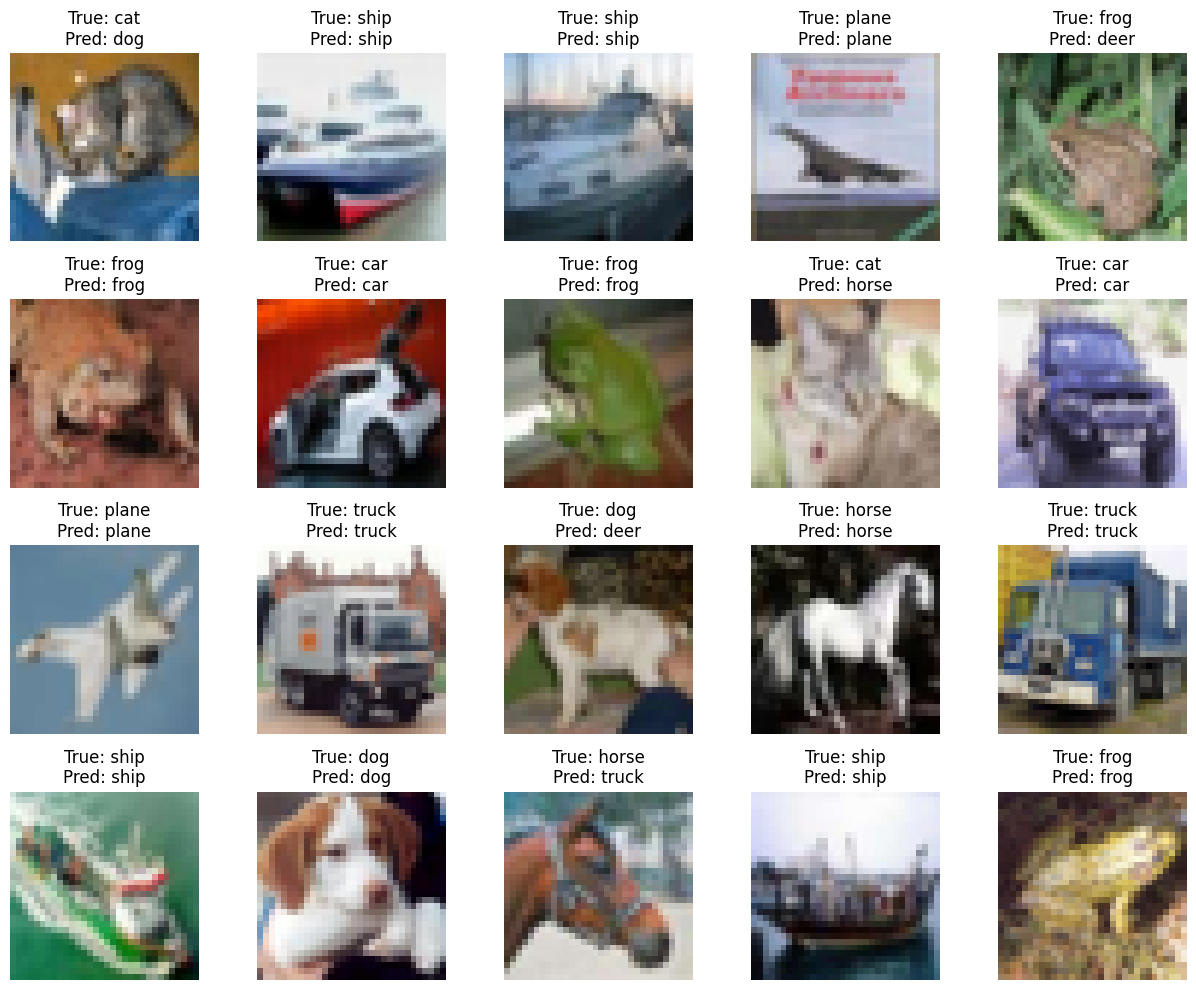

In [50]:
show_model_predictions(
    trained_resnet,
    CIFAR10_dataset.test_dataset,
    num_samples=20,
    rows=4,
    cols=5,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

__б) (5 баллов)__ Реализуйте две [техники](https://proceedings.neurips.cc/paper_files/paper/2020/file/c8cc6e90ccbff44c9cee23611711cdc4-Paper.pdf) перемешивания (shuffling-а), а именно: __RandomReshuffling__ и __ShuffleOnce__. Данные техники позволяют улучшить теоретические и практические сходимости алгоритмов.

1. __RandomReshuffling__ — это метод, при котором данные перемешиваются случайным образом в начале каждой эпохи, обеспечивая более равномерное обновление параметров.

2. __ShuffleOnce__ выполняет перемешивание один раз в начале обучения, что снижает вычислительные затраты при сохранении эффективности сходимости.

Допишите классы, представленные ниже.

In [ ]:
class RandomReshufflingSampler(torch.utils.data.Sampler):
    def __init__(self, data_source):
        self.data_source = data_source
        self.num_samples = len(data_source)
        self.indices = np.arange(self.num_samples)

    def __iter__(self):

        # YOUR CODE HERE

    def __len__(self):

        # YOUR CODE HERE

class ShuffleOnceSampler(torch.utils.data.Sampler):
    def __init__(self, data_source):
        self.data_source = data_source
        self.num_samples = len(data_source)
        self.indices = np.arange(self.num_samples)

        # YOUR CODE HERE

    def __iter__(self):

        # YOUR CODE HERE

    def __len__(self):

        # YOUR CODE HERE

Адаптируем функцию `trainer` для использования сэмплеров. Для этого необходимо поставить `shuffle=None`, чтобы убрать изначальное перемешивание и в качестве параметра `sampler=` передать необходимый сэмплер с параметрами.

In [ ]:
def shuffled_trainer(num_epochs, batch_size, model_class, criterion, optimizer_class=SGD,
                     optimizer_params=None, scheduler_class=None, scheduler_params=None, dataset=None,
                     sampler_class=None, sampler_params=None,
                     device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Универсальная функция для обучения моделей PyTorch.

    Параметры:
        num_epochs (int): Количество эпох обучения
        batch_size (int): Размер батча для DataLoader
        model_class (nn.Module): Класс модели
        criterion (nn.Module): Функция потерь
        optimizer_class (optim.Optimizer): Класс оптимизатора
        optimizer_params (dict): Параметры оптимизатора
        scheduler_class (optim.lr_scheduler): Класс планировщика скорости обучения
        scheduler_params (dict): Параметры планировщика скорости обучения
        dataset (Dataset): Объект датасета
        sampler_class (utils.data.Sampler): Класс кастомного sampler
        sampler_params (dict) Параметры sampler
        device (str): Устройство для вычислений

    Возвращает:
        model (nn.Module): Обученная модель
        metrics (dict): Словарь с логами
    """

    # Создаем загрузчики данных
    train_loader = DataLoader(
        dataset.train_dataset,
        batch_size=batch_size,
        shuffle=False,  # Используем кастомный sampler вместо shuffle
        sampler=sampler_class(dataset.train_dataset, **(sampler_params or {})) if sampler_class else None
    )
    test_loader = DataLoader(dataset.test_dataset, batch_size=batch_size, shuffle=False)

    # Инициализируем модель, оптимизатор
    model = model_class.to(device)
    optimizer = optimizer_class(model.parameters(), **(optimizer_params or {}))

    # Инициализируем планировщик
    scheduler = None
    if scheduler_class is not None:
        scheduler = scheduler_class(optimizer, **(scheduler_params or {}))

    # Метрики
    metrics = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "learning_rates": []
    }

    def train_epoch(epoch):
        model.train()

        # YOUR CODE HERE

        return train_loss, train_acc

    def test_epoch(epoch):
        model.eval()

        # YOUR CODE HERE

        return test_loss, test_acc

    # Обучение
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(epoch)
        test_loss, test_acc = test_epoch(epoch)

        # Шаг планировщика

        # YOUR CODE HERE

        # Сохраняем метрики
        metrics["train_loss"].append(train_loss)
        metrics["train_acc"].append(train_acc)
        metrics["test_loss"].append(test_loss)
        metrics["test_acc"].append(test_acc)
        metrics["learning_rates"].append(optimizer.param_groups[0]['lr'])

        # Логирование
        elapsed = time.time() - start_time
        print(f"Epoch {epoch + 1} / {num_epochs} | "
              f"LR: {metrics['learning_rates'][-1]:.2e} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}% | "
              f"Time: {elapsed:.2f}s")

    # Возвращаем модель и метрики
    return model, metrics

__д) (2 балла)__ Запустите обучение без скедулера c теми же параметрами, что и ранее, для разлиных шаффлеров. Дает ли данная техника улучшение? Запустите со скедулером. Сравните результаты и постройте сравнительные графики сходимости.

In [ ]:
# Ваше решение (Code)

In [ ]:
# Ваше решение (Code)

Запустите с любым `lr_scheduler`.

In [ ]:
# Ваше решение (Code)

Постройте сравнительные графики сходимости.

In [ ]:
# Ваше решение (Code)

Дает ли данная техника улучшение?

In [ ]:
# Ваше решение (Markdown)